# CAPSTONE PROJECT

* name: Leticia D Drasler
* pace: Part time
* Scheduled project review data/time: March 23nd, 2022, 12:00PM (Mountain Time)
* Course Instructor: Abhineet
* Blog post URL: https://callableleticia.blog/2022/03/22/capstone-project/
* GitHub repository: https://github.com/lddrasler/Sentiment-Analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.manifold import TSNE
import re

import emoji
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import word2vec

### Loading and analyzing dataset

In [2]:
# train
train = pd.read_csv('Corona_NLP_train.csv', encoding='latin-1')

# test 
test = pd.read_csv('Corona_NLP_test.csv', encoding='latin-1')

#checking
train.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
test.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [6]:
train.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [7]:
test.isna().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [8]:
train['Location'].isna().sum()

8590

In [9]:
test['Location'].isna().sum()

834

In [10]:
train['Location'][0:20]

0                        London
1                            UK
2                     Vagabonds
3                           NaN
4                           NaN
5     ÃT: 36.319708,-82.363649
6          35.926541,-78.753267
7                       Austria
8               Atlanta, GA USA
9              BHAVNAGAR,GUJRAT
10               Makati, Manila
11    Pitt Meadows, BC, Canada 
12                   Horningsea
13                  Chicago, IL
14                          NaN
15               Houston, Texas
16                 Saudi Arabia
17              Ontario, Canada
18                North America
19                   Denver, CO
Name: Location, dtype: object

In [11]:
train['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [12]:
test['Sentiment'].value_counts()

Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: Sentiment, dtype: int64

### Cleaning Train and Test Data 

In [13]:
train.drop(columns=['Location'], inplace=True)
test.drop(columns=['Location'], inplace=True)

In [14]:
#changing sentiment train and test

change_sentiment = {"Extremely Positive":2,
                    "Positive":2,
                    "Neutral":0,
                    "Negative":1,
                    "Extremely Negative":1           
                    }
train['Sentiment']=train['Sentiment'].map(change_sentiment,0)
test['Sentiment']=test['Sentiment'].map(change_sentiment,0)


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

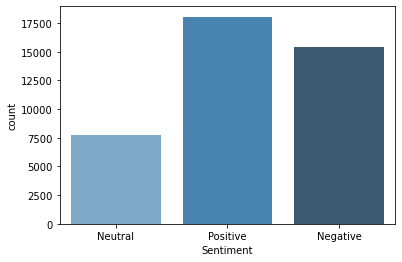

In [15]:
sns.countplot(train['Sentiment'].map({0:'Neutral', 1:'Negative',2:'Positive'}), palette="Blues_d")

In [16]:
# train
tweet_train = train["OriginalTweet"]

#test
tweet_test = test['OriginalTweet']

#checking train
tweet_train[0:10]

0    @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1    advice Talk to your neighbours family to excha...
2    Coronavirus Australia: Woolworths to give elde...
3    My food stock is not the only one which is emp...
4    Me, ready to go at supermarket during the #COV...
5    As news of the regionÂs first confirmed COVID...
6    Cashier at grocery store was sharing his insig...
7    Was at the supermarket today. Didn't buy toile...
8    Due to COVID-19 our retail store and classroom...
9    For corona prevention,we should stop to buy th...
Name: OriginalTweet, dtype: object

### Preprocessing 

In [17]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [18]:
def preprocess(tweets):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in tweets:
        tweet = tweet.lower()
        
        # Replace all URls with ''
        tweet = re.sub(urlPattern,"",tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME "".
        tweet = re.sub(r"(?:\@|https?\://)\S+"," ",tweet)   
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [19]:
#train
train_text = pd.Series(preprocess(tweet_train))

#test
test_text = pd.Series(preprocess(tweet_test))

#checking
train_text

0                                                 and and 
1        advice talk to your neighbour family to exchan...
2        coronavirus australia woolworth to give elderl...
3        my food stock is not the only one which is emp...
4        me ready to go at supermarket during the covid...
                               ...                        
41152    airline pilot offering to stock supermarket sh...
41153    response to complaint not provided citing covi...
41154    you know it getting tough when is rationing to...
41155    is it wrong that the smell of hand sanitizer i...
41156    well new used rift are going for 700 00 on ama...
Length: 41157, dtype: object

## Tokenization

In [20]:
# TOKENS TRAIN
train_tokens = train_text.map(word_tokenize)
train_tokens

0                                               [and, and]
1        [advice, talk, to, your, neighbour, family, to...
2        [coronavirus, australia, woolworth, to, give, ...
3        [my, food, stock, is, not, the, only, one, whi...
4        [me, ready, to, go, at, supermarket, during, t...
                               ...                        
41152    [airline, pilot, offering, to, stock, supermar...
41153    [response, to, complaint, not, provided, citin...
41154    [you, know, it, getting, tough, when, is, rati...
41155    [is, it, wrong, that, the, smell, of, hand, sa...
41156    [well, new, used, rift, are, going, for, 700, ...
Length: 41157, dtype: object

In [21]:
# TOKENS TEST
test_tokens = test_text.map(word_tokenize)
test_tokens

0       [trending, new, yorkers, encounter, empty, sup...
1       [when, couldn, find, hand, sanitizer, at, fred...
2       [find, out, how, you, can, protect, yourself, ...
3       [panic, buying, hit, newyork, city, a, anxious...
4       [toiletpaper, dunnypaper, coronavirus, coronav...
                              ...                        
3793    [meanwhile, in, supermarket, in, israel, peopl...
3794    [did, you, panic, buy, lot, of, non, perishabl...
3795    [asst, prof, of, economics, wa, on, talking, a...
3796    [gov, need, to, do, somethings, instead, of, b...
3797    [and, member, are, committed, to, the, safety,...
Length: 3798, dtype: object

### STOP WORDS

In [22]:
#STOP WORDS
import nltk
from nltk.corpus import stopwords
stopwords_english = stopwords.words('english')

In [23]:
def rem_stopwords(train_tokens):
    text_filtered = []
    for tweet in train_tokens:
        tweet_filtered=[]
        for word in tweet:            
            if word not in stopwords_english:
                tweet_filtered.append(word)
        text_filtered.append(tweet_filtered)
    return text_filtered

train_stopword =pd.Series(rem_stopwords(train_tokens))
train_stopword

0                                                       []
1        [advice, talk, neighbour, family, exchange, ph...
2        [coronavirus, australia, woolworth, give, elde...
3        [food, stock, one, empty, please, panic, enoug...
4        [ready, go, supermarket, covid19, outbreak, pa...
                               ...                        
41152    [airline, pilot, offering, stock, supermarket,...
41153    [response, complaint, provided, citing, covid,...
41154    [know, getting, tough, rationing, toilet, pape...
41155    [wrong, smell, hand, sanitizer, starting, turn...
41156    [well, new, used, rift, going, 700, 00, amazon...
Length: 41157, dtype: object

In [24]:
#stop word test data

test_stopword = pd.Series(rem_stopwords(test_tokens))
test_stopword

0       [trending, new, yorkers, encounter, empty, sup...
1       [find, hand, sanitizer, fred, meyer, turned, a...
2                [find, protect, loved, one, coronavirus]
3       [panic, buying, hit, newyork, city, anxious, s...
4       [toiletpaper, dunnypaper, coronavirus, coronav...
                              ...                        
3793    [meanwhile, supermarket, israel, people, dance...
3794    [panic, buy, lot, non, perishable, item, echo,...
3795    [asst, prof, economics, wa, talking, recent, r...
3796    [gov, need, somethings, instead, biar, je, rak...
3797    [member, committed, safety, employee, end, use...
Length: 3798, dtype: object

In [25]:
# replacing DF with cleaned tweets

#train
train['text'] = train_stopword
train.drop(columns='OriginalTweet', axis=1, inplace=True)
#test
test['text'] = test_stopword
test.drop(columns='OriginalTweet', axis=1, inplace=True)

In [26]:
def is_blank(tokenized_text):
    return tokenized_text if tokenized_text !=[] else np.nan

In [27]:
#train 

train.text = train.text.map(is_blank)

#test

test.text = test.text.map(is_blank)

In [28]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [29]:
train.text

1        [advice, talk, neighbour, family, exchange, ph...
2        [coronavirus, australia, woolworth, give, elde...
3        [food, stock, one, empty, please, panic, enoug...
4        [ready, go, supermarket, covid19, outbreak, pa...
5        [news, region, first, confirmed, covid, 19, ca...
                               ...                        
41152    [airline, pilot, offering, stock, supermarket,...
41153    [response, complaint, provided, citing, covid,...
41154    [know, getting, tough, rationing, toilet, pape...
41155    [wrong, smell, hand, sanitizer, starting, turn...
41156    [well, new, used, rift, going, 700, 00, amazon...
Name: text, Length: 41128, dtype: object

In [30]:
total_vocab = set(word for tweet in train.text for word in tweet)
len(total_vocab)

41575

### Word Cloud

In [31]:
train[train.Sentiment==2].text

1        [advice, talk, neighbour, family, exchange, ph...
2        [coronavirus, australia, woolworth, give, elde...
3        [food, stock, one, empty, please, panic, enoug...
5        [news, region, first, confirmed, covid, 19, ca...
6        [cashier, grocery, store, wa, sharing, insight...
                               ...                        
41146    [gold, price, rose, year, high, today, due, co...
41148    [uv, light, sterilizer, sanitizer, mask, mobil...
41150    [never, situation, amp, world, going, supermar...
41151    [definitely, man, feel, like, fall, need, hono...
41154    [know, getting, tough, rationing, toilet, pape...
Name: text, Length: 18044, dtype: object

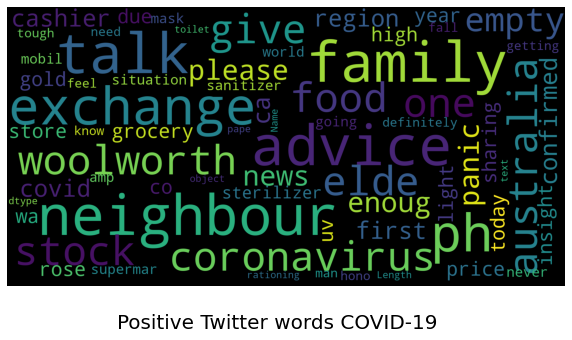

In [32]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

word_cloud = WordCloud(
                    background_color='black',
                    stopwords=set(STOPWORDS),
                    max_words=200,
                    max_font_size=40,
                    scale=5).generate(str(train[train.Sentiment==2].text))
fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
fig.suptitle('Positive Twitter words COVID-19', fontsize=20)
fig.subplots_adjust(top=2.3)
plt.imshow(word_cloud)
plt.show()

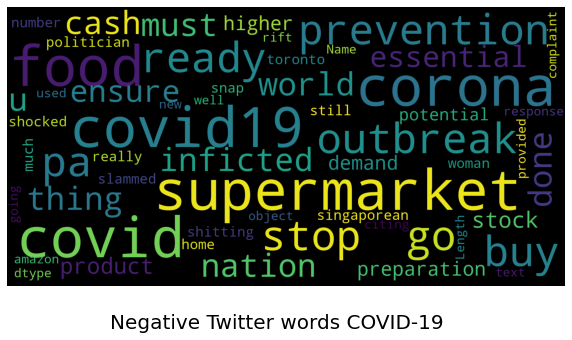

In [33]:
word_cloud = WordCloud(
                    background_color='black',
                    stopwords=set(STOPWORDS),
                    max_words=200,
                    max_font_size=40,
                    scale=5).generate(str(train[train.Sentiment==1].text))
fig = plt.figure(2, figsize=(10,10))
plt.axis('off')
fig.suptitle('Negative Twitter words COVID-19', fontsize=20)
fig.subplots_adjust(top=2.3)
plt.imshow(word_cloud)
plt.show()

## GloVe

In [34]:
glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocab:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector
            
len(glove.keys())

26221

## Vectorization  

In [35]:
#VECTORIZATION 

class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

## Baseline Models

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Random Foresut', RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression())])

In [37]:
# defining X and Y for baseline
X_train = train['text']
y_train = train['Sentiment']

X_test = test['text']
y_test = test['Sentiment']

In [38]:
models = [('Random Forest', rf),
          ('Support Vector Machine', svc),
          ('Logistic Regression', lr)]

In [192]:
scores = [(name, cross_val_score(model, X_train, y_train, cv=2).mean()) for name, model, in models]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   17.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


In [193]:
scores

[('Random Forest', 0.5950447383777475),
 ('Support Vector Machine', 0.6281851779809375),
 ('Logistic Regression', 0.6108976852752384)]

In [194]:
rf.fit(X_train, y_train)
svc.fit(X_train, y_train)
lr.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   31.8s finished


Pipeline(steps=[('Word2Vec Vectorizer',
                 <__main__.W2vVectorizer object at 0x00000145F8793FC8>),
                ('Logistic Regression', LogisticRegression())])

In [195]:
# applying to test

In [196]:
print(rf.score(X_test,y_test))
print(svc.score(X_test, y_test))
print(lr.score(X_test, y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


0.5974710221285564
0.6298735511064278
0.6140674394099052


## Neural Network with Embedding

In [39]:
# untokenizing to fit on keras layers

def tokens_to_string(tokenized_text):
    return " ".join(word for word in tokenized_text)

In [40]:
# defining X and Y for keras

# train
X_train = train['text'].map(tokens_to_string)
y_train_dummy = pd.get_dummies(y_train).values

# test
X_test = test['text'].map(tokens_to_string)
y_test_dummy = pd.get_dummies(y_test).values

In [119]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

In [120]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_headlines = tokenizer.texts_to_sequences(X_train)
X_t = sequence.pad_sequences(list_tokenized_headlines, maxlen=100)

X_test=sequence.pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)

In [121]:
model = Sequential()

In [122]:
embedding_size = 128
model.add(Embedding(41576, embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [123]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [124]:
from tensorflow import keras
callbacks=[keras.callbacks.ModelCheckpoint('embedding_NN.keras', save_best_only=False)]

In [125]:
model.fit(X_t, y_train_dummy, epochs=2, batch_size=32, validation_split=0.2,callbacks=callbacks)

Epoch 1/2
1029/1029 [==============================] - 98s 93ms/step - loss: 0.7716 - accuracy: 0.6613 - val_loss: 0.4874 - val_accuracy: 0.8281
Epoch 2/2
1029/1029 [==============================] - 99s 96ms/step - loss: 0.4699 - accuracy: 0.8435 - val_loss: 0.4712 - val_accuracy: 0.8270


### Fitting test final model


In [126]:
loss, acc = model.evaluate(X_test,y_test_dummy)

119/119 [==============================] - 2s 14ms/step - loss: 0.5132 - accuracy: 0.8119


In [127]:
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 81.190729


### Words Interpretation / Tensor Board

In [128]:
embeddings=model.layers[0].get_weights()[0][1:]

In [129]:
embeddings.shape

(41575, 128)

In [130]:
len(tokenizer.word_index.items())

41575

In [131]:
words_embeddings = {w:embeddings[idx-1] for w, idx in tokenizer.word_index.items()}

In [132]:
import os
log_dir = 'logs'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

In [133]:
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for subwords in words_embeddings.keys():
        f.write("{}\n".format(subwords))

In [134]:
weights=tf.Variable(model.layers[0].get_weights()[0][1:])
checkpoint = tf.train.Checkpoint(embedding=weights)

In [135]:

checkpoint.save(os.path.join(log_dir,'embedding.ckpt'))

'logs\\embedding.ckpt-1'

In [136]:
from tensorboard.plugins import projector
config = projector.ProjectorConfig()
embedding=config.embeddings.add()

In [137]:
embedding.tensor_name = 'embedding/.ATTRIBUTES/VARIABLE_VALUE'

In [138]:
embedding.metadata_path = 'metadata.tsv'

In [139]:
projector.visualize_embeddings(log_dir,config)